In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


In [17]:
DEMAND_DATA = 'half-hourly-system-demand-data-from-2-feb-2012-onwards.csv'

with open(DEMAND_DATA, 'r') as f:
  df = pd.read_csv(f)

In [54]:
df['datetime'] = df["date"] + " " + df["period_ending_time"]
df['datetime'] = pd.to_datetime(df["datetime"]).dt.tz_localize(tz="Asia/Singapore")

In [38]:
df

,date,period_ending_time,system_demand_actual,nem_demand_actual,nem_demand_forecast,datetime
0,2012-02-06,00:30,4526.68,na,na,2012-02-06 00:30:00
1,2012-02-06,01:00,4436.09,na,na,2012-02-06 01:00:00
2,2012-02-06,01:30,4361.24,na,na,2012-02-06 01:30:00
3,2012-02-06,02:00,4295.23,na,na,2012-02-06 02:00:00
4,2012-02-06,02:30,4233.17,na,na,2012-02-06 02:30:00
...,...,...,...,...,...,...
75931,2016-06-05,22:00,5862.00,5784,5783,2016-06-05 22:00:00
75932,2016-06-05,22:30,5756.00,5684,5679,2016-06-05 22:30:00
75933,2016-06-05,23:00,5674.00,5592,5606,2016-06-05 23:00:00
75934,2016-06-05,23:30,5566.00,5486,5499,2016-06-05 23:30:00


In [39]:
df.dtypes

date                            object
period_ending_time              object
system_demand_actual           float64
nem_demand_actual               object
nem_demand_forecast             object
datetime                datetime64[ns]
dtype: object

In [128]:
## Extrapolate from 2012--2016 data to 2020 and 2021.

from statistics import geometric_mean
date_ratios = {}

for index, row in df.iterrows():
    if (row['datetime'] > pd.Timestamp(2013,2,6)):
        break
    else:
        d = row['datetime']
        #print(d)
        ratios = []
        for i in range(1,6):
            x1 = pd.Timedelta(days=365*(i-1))
            x2 = pd.Timedelta(days=365*i)
            d1 = row['datetime'] + x1
            d2 = row['datetime'] + x2
            # print(d1)
            # print(d2)
            # find the row where date is
            r1 = df.loc[df['datetime'] == d1]
            r2 = df.loc[df['datetime'] == d2]
            
            if r2.empty or r1.empty:
                break
            else:
                q1 = r1['system_demand_actual'].array[0]
                q2 = r2['system_demand_actual'].array[0]
                ratio = q2/q1
                # print(ratio)
                ratios.append(ratio)
                #print(q2 - q1)
                #ratio = q2/q1
                #print(ratio)
        # print(d)        
        # print(ratios)
        # print(geometric_mean(ratios))
    date_ratios[row['datetime']] = geometric_mean(ratios)

date_ratios

{Timestamp('2012-02-06 00:30:00'): 1.037656254125665,
 Timestamp('2012-02-06 01:00:00'): 1.0357861879471966,
 Timestamp('2012-02-06 01:30:00'): 1.0349677771065156,
 Timestamp('2012-02-06 02:00:00'): 1.0345863285993493,
 Timestamp('2012-02-06 02:30:00'): 1.034804993079988,
 Timestamp('2012-02-06 03:00:00'): 1.0343933886241958,
 Timestamp('2012-02-06 03:30:00'): 1.0342203886913757,
 Timestamp('2012-02-06 04:00:00'): 1.0326516790349196,
 Timestamp('2012-02-06 04:30:00'): 1.0341160723708096,
 Timestamp('2012-02-06 05:00:00'): 1.0335196638376876,
 Timestamp('2012-02-06 05:30:00'): 1.0327450748590588,
 Timestamp('2012-02-06 06:00:00'): 1.0305125168780227,
 Timestamp('2012-02-06 06:30:00'): 1.02809567652761,
 Timestamp('2012-02-06 07:00:00'): 1.0260569477708732,
 Timestamp('2012-02-06 07:30:00'): 1.0240138233758949,
 Timestamp('2012-02-06 08:00:00'): 1.0214467474147795,
 Timestamp('2012-02-06 08:30:00'): 1.017767632891981,
 Timestamp('2012-02-06 09:00:00'): 1.0137070502649794,
 Timestamp('201

In [119]:
len(date_ratios)

17568

In [200]:
df2 = df.drop(columns=['nem_demand_actual', 'nem_demand_forecast', 'date', 'period_ending_time'])

In [201]:
df2 = df2.reindex(columns=['datetime', 'system_demand_actual'])

In [202]:
df2

,datetime,system_demand_actual
0,2012-02-06 00:30:00,4526.68
1,2012-02-06 01:00:00,4436.09
2,2012-02-06 01:30:00,4361.24
3,2012-02-06 02:00:00,4295.23
4,2012-02-06 02:30:00,4233.17
...,...,...
75931,2016-06-05 22:00:00,5862.00
75932,2016-06-05 22:30:00,5756.00
75933,2016-06-05 23:00:00,5674.00
75934,2016-06-05 23:30:00,5566.00


In [168]:
def nowcast(row):
    d = pd.Timedelta(days=365*8)
    # print(row)
    # print(row['datetime'])
    ratio = date_ratios[row['datetime']]
    quantity = ratio ** 8 * row['system_demand_actual']
    return [row['datetime'] + d, quantity]
    

In [179]:
# We're now going to nowcast (extrapolate out of the data).
# Take the earliest year (2012) and nowcast to 2020.

rows = []

rows = ((df2.loc[df2['datetime'] < pd.Timestamp(2013,2,6)]).apply(nowcast, axis=1))

In [180]:
print(rows)

0        [2020-02-04 00:30:00, 6084.261312926913]
1        [2020-02-04 01:00:00, 5877.075532732658]
2         [2020-02-04 01:30:00, 5741.49003494419]
3        [2020-02-04 02:00:00, 5637.938131368988]
4        [2020-02-04 02:30:00, 5565.879943399389]
                           ...                   
17562    [2021-02-03 21:30:00, 6173.636890339916]
17563    [2021-02-03 22:00:00, 6235.551999125721]
17564    [2021-02-03 22:30:00, 6256.186640666296]
17565     [2021-02-03 23:00:00, 6249.70921504301]
17566    [2021-02-03 23:30:00, 6143.656117222844]
Length: 17567, dtype: object


In [187]:
print(rows.iloc[0][0])

2020-02-04 00:30:00


In [193]:
rows2 = []

rows2 = [[a, b] for (a,b) in rows]

df3 = pd.DataFrame(rows2, columns=['datetime', 'system_demand_actual'])

In [203]:
df2 = df2.append(df3)

In [204]:
df2

,datetime,system_demand_actual
0,2012-02-06 00:30:00,4526.680000
1,2012-02-06 01:00:00,4436.090000
2,2012-02-06 01:30:00,4361.240000
3,2012-02-06 02:00:00,4295.230000
4,2012-02-06 02:30:00,4233.170000
...,...,...
17562,2021-02-03 21:30:00,6173.636890
17563,2021-02-03 22:00:00,6235.551999
17564,2021-02-03 22:30:00,6256.186641
17565,2021-02-03 23:00:00,6249.709215


In [205]:
df3

,datetime,system_demand_actual
0,2020-02-04 00:30:00,6084.261313
1,2020-02-04 01:00:00,5877.075533
2,2020-02-04 01:30:00,5741.490035
3,2020-02-04 02:00:00,5637.938131
4,2020-02-04 02:30:00,5565.879943
...,...,...
17562,2021-02-03 21:30:00,6173.636890
17563,2021-02-03 22:00:00,6235.551999
17564,2021-02-03 22:30:00,6256.186641
17565,2021-02-03 23:00:00,6249.709215


In [208]:
df2 = df2.reset_index()

In [228]:
df2['datetime'] = df2['datetime'].dt.tz_localize(tz="Asia/Singapore")

In [231]:
df2

,index,datetime,system_demand_actual
0,0,2012-02-06 00:30:00+08:00,4526.680000
1,1,2012-02-06 01:00:00+08:00,4436.090000
2,2,2012-02-06 01:30:00+08:00,4361.240000
3,3,2012-02-06 02:00:00+08:00,4295.230000
4,4,2012-02-06 02:30:00+08:00,4233.170000
...,...,...,...
93498,17562,2021-02-03 21:30:00+08:00,6173.636890
93499,17563,2021-02-03 22:00:00+08:00,6235.551999
93500,17564,2021-02-03 22:30:00+08:00,6256.186641
93501,17565,2021-02-03 23:00:00+08:00,6249.709215


In [260]:
def filt(df, y, m, d):
    return df.loc[(df['datetime'] >= pd.Timestamp(y,m,d).tz_localize(tz="Asia/Singapore")) &
        (df['datetime'] < pd.Timestamp(y,m,d+1).tz_localize(tz="Asia/Singapore"))]

In [262]:
df_filter

,index,datetime,system_demand_actual
82511,6575,2020-06-20 00:00:00+08:00,6225.660492
82512,6576,2020-06-20 00:30:00+08:00,6128.222245
82513,6577,2020-06-20 01:00:00+08:00,6012.577825
82514,6578,2020-06-20 01:30:00+08:00,5919.409911
82515,6579,2020-06-20 02:00:00+08:00,5884.024053
82516,6580,2020-06-20 02:30:00+08:00,5787.950683
82517,6581,2020-06-20 03:00:00+08:00,5625.617016
82518,6582,2020-06-20 03:30:00+08:00,5579.678085
82519,6583,2020-06-20 04:00:00+08:00,5528.802521
82520,6584,2020-06-20 04:30:00+08:00,5555.726732


In [265]:
GHI_DATA = 'DRW_07-2019_06-2020_GHI.csv'

with open(GHI_DATA, 'r') as f:
  ghi_df = pd.read_csv(f)

ghi_df = ghi_df.drop(columns=['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'])

# Let's calculate the power produced by 1m2 of solar panel.
# After using the stats for the solar panel (3)

# The solar panel has a width of 5550mm and a length of 37330mm
# The area is therefore 207.8 sq m.

# It produces 34.2 kWp at peak with 207.8 sqm which means that 
# the efficiency is 16.4%.
# That is for, 1kW/m2 of irradiance, you get 0.16kWp per m2 of the solar panel.

# There is also a is a 15% loss due to cloud cover, fouling, etc.

# Hence, the PVOUT average per GHI is equal to 

ghi_df['PVOUT_AVG'] = ghi_df['GHI_AVG'] * 0.164 * 0.85

print(ghi_df[288:577])

ghi_df['time'] = pd.to_datetime(ghi_df['Time'], dayfirst=True)
ghi_df = ghi_df[ghi_df['GHI_AVG'].notnull()]

# localise timezone to make timezone aware

ghi_df['time2'] = ghi_df['time'].dt.tz_localize(tz='Australia/Darwin')

# convert to Singapore time
ghi_df['datetime'] = pd.DatetimeIndex(ghi_df['time2']).tz_convert(tz='Asia/Singapore')

# drop the columns

ghi_df = ghi_df.drop(columns=['Time', 'Timezone', 'time2'])

                 Time Timezone   GHI_AVG  PVOUT_AVG
288  02/07/2019 00:00     ACST -2.288212  -0.318977
289  02/07/2019 00:05     ACST -2.207044  -0.307662
290  02/07/2019 00:10     ACST -2.097399  -0.292377
291  02/07/2019 00:15     ACST -2.098669  -0.292554
292  02/07/2019 00:20     ACST -2.126001  -0.296364
..                ...      ...       ...        ...
572  02/07/2019 23:40     ACST -2.567105  -0.357854
573  02/07/2019 23:45     ACST -2.545830  -0.354889
574  02/07/2019 23:50     ACST -2.489317  -0.347011
575  02/07/2019 23:55     ACST -2.493965  -0.347659
576  03/07/2019 00:00     ACST -2.455383  -0.342280

[289 rows x 4 columns]


In [329]:
# For the shortest day of the year, 2020-06-20 (summer equinox)

y = 2020
m = 2
d = 22

In [330]:
gdf_filter

,GHI_AVG,PVOUT_AVG,time,datetime
67986,-0.344179,-0.047979,2020-02-22 01:30:00,2020-02-22 00:00:00+08:00
67987,-0.357651,-0.049857,2020-02-22 01:35:00,2020-02-22 00:05:00+08:00
67988,-0.382727,-0.053352,2020-02-22 01:40:00,2020-02-22 00:10:00+08:00
67989,-0.623739,-0.086949,2020-02-22 01:45:00,2020-02-22 00:15:00+08:00
67990,-1.074771,-0.149823,2020-02-22 01:50:00,2020-02-22 00:20:00+08:00
...,...,...,...,...
68269,-1.177126,-0.164091,2020-02-23 01:05:00,2020-02-22 23:35:00+08:00
68270,-1.134651,-0.158170,2020-02-23 01:10:00,2020-02-22 23:40:00+08:00
68271,-1.099309,-0.153244,2020-02-23 01:15:00,2020-02-22 23:45:00+08:00
68272,-1.083564,-0.151049,2020-02-23 01:20:00,2020-02-22 23:50:00+08:00


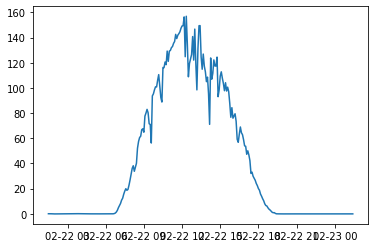

In [331]:
plt.plot(gdf_filter['time'], gdf_filter['PVOUT_AVG'])

In [327]:
df_filter

,index,datetime,system_demand_actual


In [364]:
mdf = pd.merge(df2, ghi_df, on="datetime", how='right')
mdf['system_demand_actual'] = mdf['system_demand_actual'] * 1e6

In [366]:
mdf = mdf.dropna()

In [373]:
mdf = mdf.reset_index(drop=True)

In [565]:
mdf.to_csv('cleaned_data.csv', index=False)

In [411]:
mdf

,index,datetime,system_demand_actual,GHI_AVG,PVOUT_AVG,time,net_supply
0,832.0,2020-02-21 08:30:00+08:00,6.152076e+09,718.273340,100.127304,2020-02-21 10:00:00,1.384335e+10
1,833.0,2020-02-21 09:00:00+08:00,6.357507e+09,849.052595,118.357932,2020-02-21 10:30:00,1.727857e+10
2,834.0,2020-02-21 09:30:00+08:00,6.525566e+09,754.479164,105.174395,2020-02-21 11:00:00,1.447776e+10
3,835.0,2020-02-21 10:00:00+08:00,6.659675e+09,1036.819147,144.532589,2020-02-21 11:30:00,2.220348e+10
4,836.0,2020-02-21 10:30:00+08:00,6.769155e+09,1003.511913,139.889561,2020-02-21 12:00:00,2.116679e+10
...,...,...,...,...,...,...,...
6166,7003.0,2020-06-28 22:00:00+08:00,8.801746e+09,-3.585504,-0.499819,2020-06-28 23:30:00,-8.901560e+09
6167,7004.0,2020-06-28 22:30:00+08:00,8.690089e+09,-3.369714,-0.469738,2020-06-29 00:00:00,-8.783895e+09
6168,7005.0,2020-06-28 23:00:00+08:00,8.365280e+09,-3.589336,-0.500353,2020-06-29 00:30:00,-8.465201e+09
6169,7006.0,2020-06-28 23:30:00+08:00,8.077377e+09,-3.313548,-0.461909,2020-06-29 01:00:00,-8.169620e+09


In [394]:
areas_needed = []

for m in range(2,7):
    y = 2020
    for d in range(1, 31):   
        try:
            mdf_filter = filt(mdf, y, m, d)
            area = calc_area_needed(mdf_filter)
            # plot_graph(mdf, area)
            if (area > 0):
                print(f"Hectares needed for {y} {m} {d}: {area/10000}")
                areas_needed.append({"date": pd.Timestamp(y,m,d), "area": area/10000})
        except ValueError:
            continue

Hectares needed for 2020 2 21: 16540.0
Hectares needed for 2020 2 22: 15070.0
Hectares needed for 2020 2 23: 18420.0
Hectares needed for 2020 2 24: 18480.0
Hectares needed for 2020 2 25: 14340.0
Hectares needed for 2020 2 26: 19100.0
Hectares needed for 2020 2 27: 39620.0
Hectares needed for 2020 2 28: 25830.0
Hectares needed for 2020 3 1: 17740.0
Hectares needed for 2020 3 2: 22290.0
Hectares needed for 2020 3 3: 32850.0
Hectares needed for 2020 3 4: 14380.0
Hectares needed for 2020 3 5: 14860.0
Hectares needed for 2020 3 6: 15320.0
Hectares needed for 2020 3 7: 25480.0
Hectares needed for 2020 3 8: 36340.0
Hectares needed for 2020 3 9: 155410.0
Hectares needed for 2020 3 10: 16980.0
Hectares needed for 2020 3 11: 14450.0
Hectares needed for 2020 3 12: 12190.0
Hectares needed for 2020 3 13: 15730.0
Hectares needed for 2020 3 14: 18670.0
Hectares needed for 2020 3 15: 17520.0
Hectares needed for 2020 3 16: 16900.0
Hectares needed for 2020 3 17: 18560.0
Hectares needed for 2020 3 18: 17

In [403]:
area_needed_df = pd.DataFrame(areas_needed)

In [404]:
area_needed_df

,date,area
0,2020-02-21,16540.0
1,2020-02-22,15070.0
2,2020-02-23,18420.0
3,2020-02-24,18480.0
4,2020-02-25,14340.0
...,...,...
120,2020-06-24,22270.0
121,2020-06-25,19840.0
122,2020-06-26,17900.0
123,2020-06-27,23700.0


In [574]:
area_needed_df.to_csv('area_needed_every_day.csv')

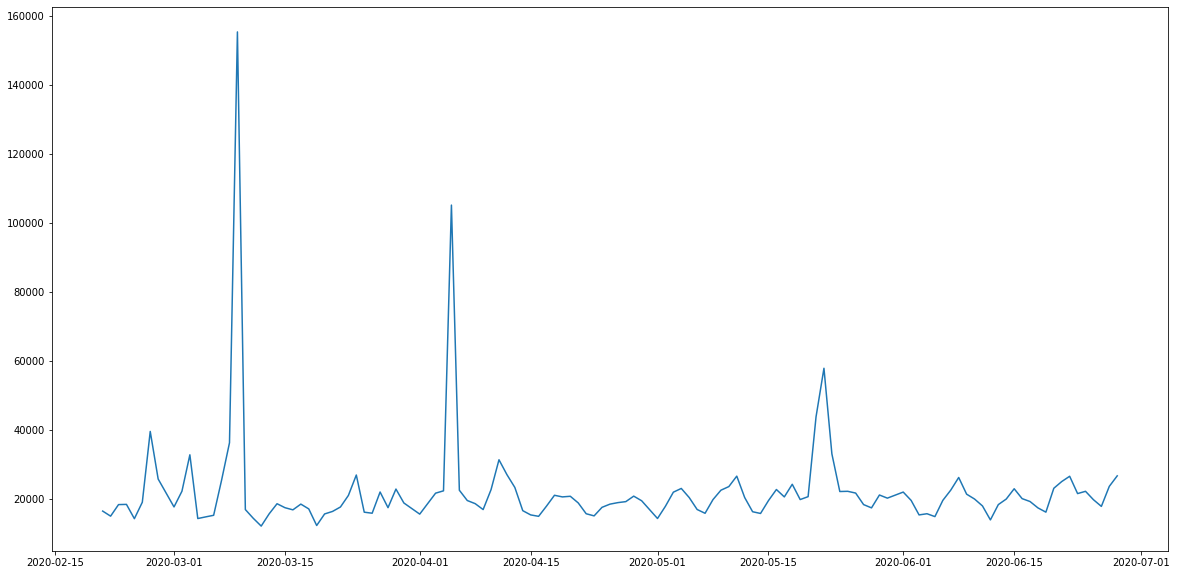

In [402]:
fig, ax = plt.subplots(figsize = [20,10])
plt.plot(area_needed_df['date'], area_needed_df['area'])

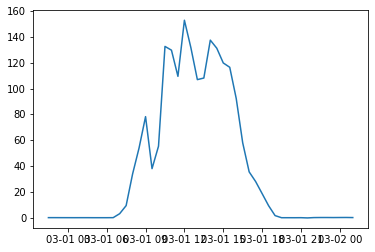

In [288]:
plt.plot(mdf['time'], mdf['PVOUT_AVG'])

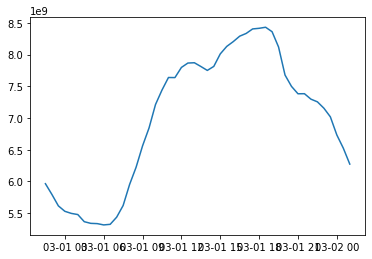

In [289]:
plt.plot(mdf['time'], mdf['system_demand_actual'])

In [475]:
mdf

,index,datetime,system_demand_actual,GHI_AVG,PVOUT_AVG,time,net_supply
0,832.0,2020-02-21 08:30:00+08:00,6.152076e+09,718.273340,100.127304,2020-02-21 10:00:00,1.384335e+10
1,833.0,2020-02-21 09:00:00+08:00,6.357507e+09,849.052595,118.357932,2020-02-21 10:30:00,1.727857e+10
2,834.0,2020-02-21 09:30:00+08:00,6.525566e+09,754.479164,105.174395,2020-02-21 11:00:00,1.447776e+10
3,835.0,2020-02-21 10:00:00+08:00,6.659675e+09,1036.819147,144.532589,2020-02-21 11:30:00,2.220348e+10
4,836.0,2020-02-21 10:30:00+08:00,6.769155e+09,1003.511913,139.889561,2020-02-21 12:00:00,2.116679e+10
...,...,...,...,...,...,...,...
6166,7003.0,2020-06-28 22:00:00+08:00,8.801746e+09,-3.585504,-0.499819,2020-06-28 23:30:00,-8.901560e+09
6167,7004.0,2020-06-28 22:30:00+08:00,8.690089e+09,-3.369714,-0.469738,2020-06-29 00:00:00,-8.783895e+09
6168,7005.0,2020-06-28 23:00:00+08:00,8.365280e+09,-3.589336,-0.500353,2020-06-29 00:30:00,-8.465201e+09
6169,7006.0,2020-06-28 23:30:00+08:00,8.077377e+09,-3.313548,-0.461909,2020-06-29 01:00:00,-8.169620e+09


In [511]:
area_needed_df.dtypes

date    datetime64[ns, Asia/Singapore]
area                           float64
dtype: object

In [571]:
area_needed_df['datetime'] = area_needed_df['date']

In [572]:
area_needed_df['date'] = area_needed_df['datetime'].dt.date

In [573]:
area_needed_df

,date,area,datetime
0,2020-02-21,16540.0,2020-02-21 00:00:00+08:00
1,2020-02-22,15070.0,2020-02-22 00:00:00+08:00
2,2020-02-23,18420.0,2020-02-23 00:00:00+08:00
3,2020-02-24,18480.0,2020-02-24 00:00:00+08:00
4,2020-02-25,14340.0,2020-02-25 00:00:00+08:00
...,...,...,...
120,2020-06-24,22270.0,2020-06-24 00:00:00+08:00
121,2020-06-25,19840.0,2020-06-25 00:00:00+08:00
122,2020-06-26,17900.0,2020-06-26 00:00:00+08:00
123,2020-06-27,23700.0,2020-06-27 00:00:00+08:00


In [483]:
mdf['datetime'].dt.normalize()

0      2020-02-21 00:00:00+08:00
1      2020-02-21 00:00:00+08:00
2      2020-02-21 00:00:00+08:00
3      2020-02-21 00:00:00+08:00
4      2020-02-21 00:00:00+08:00
                  ...           
6166   2020-06-28 00:00:00+08:00
6167   2020-06-28 00:00:00+08:00
6168   2020-06-28 00:00:00+08:00
6169   2020-06-28 00:00:00+08:00
6170   2020-06-29 00:00:00+08:00
Name: datetime, Length: 6171, dtype: datetime64[ns, Asia/Singapore]

In [549]:
def multiply_area(r, area_df):
    r_ts = r['datetime'].normalize()
    area = area_df.loc[area_df['date'] == r_ts]['area'].values
    if len(area):
        return area[0]
    else:
        return 0

In [550]:
mdf['area'] = mdf.apply(multiply_area, axis=1, args=[area_needed_df])

In [554]:
mdf = mdf.drop(columns='net_supply')

In [556]:
mdf = mdf.drop(columns='time')

In [561]:
mdf['date'] = mdf['datetime'].dt.date

In [564]:
mdf

,datetime,date,system_demand_actual,GHI_AVG,PVOUT_AVG,area
0,2020-02-21 08:30:00+08:00,2020-02-21,6.152076e+09,718.273340,100.127304,16540.0
1,2020-02-21 09:00:00+08:00,2020-02-21,6.357507e+09,849.052595,118.357932,16540.0
2,2020-02-21 09:30:00+08:00,2020-02-21,6.525566e+09,754.479164,105.174395,16540.0
3,2020-02-21 10:00:00+08:00,2020-02-21,6.659675e+09,1036.819147,144.532589,16540.0
4,2020-02-21 10:30:00+08:00,2020-02-21,6.769155e+09,1003.511913,139.889561,16540.0
...,...,...,...,...,...,...
6166,2020-06-28 22:00:00+08:00,2020-06-28,8.801746e+09,-3.585504,-0.499819,26750.0
6167,2020-06-28 22:30:00+08:00,2020-06-28,8.690089e+09,-3.369714,-0.469738,26750.0
6168,2020-06-28 23:00:00+08:00,2020-06-28,8.365280e+09,-3.589336,-0.500353,26750.0
6169,2020-06-28 23:30:00+08:00,2020-06-28,8.077377e+09,-3.313548,-0.461909,26750.0


In [563]:
mdf = mdf.reindex(columns=['datetime', 'date', 'system_demand_actual',
                          'GHI_AVG', 'PVOUT_AVG', 'area'])

In [388]:
def calc_area_needed(mdf):
    AREA = 0
    
    # First check if dataframe is empty
    
    if (len(mdf) == 0):
        return 0

    for a in range(0, 10000000000, 100000):
        total_net_supply = (((mdf['PVOUT_AVG'] * a) - mdf['system_demand_actual']).sum()) /2
        if total_net_supply > 0:
            # print("Supply exceeds demand")
            # print((mdf['PVOUT_AVG'] * a).sum()/2)
            # print((mdf['system_demand_actual']).sum()/2)
            # print(total_net_supply)
            # print(a)
            AREA = a
            break

    # mdf['net_supply'] = ((mdf['PVOUT_AVG'] * AREA) - mdf['system_demand_actual'])
    return AREA

In [400]:
def plot_graph(mdf, area):
    fig, ax = plt.subplots(figsize = [10,10])
    plt.plot(mdf['time'], mdf['PVOUT_AVG'] * area)
    plt.plot(mdf['time'], mdf['system_demand_actual'])
    plt.plot(mdf['time'], mdf['PVOUT_AVG'] * area - mdf['system_demand_actual'])
    ax.axhline(0, color='k')
    ax.fill_between(mdf['time'], 0, mdf['net_supply'], color = 'lightgreen')